# Pix2Pix Model

This notebook was obtained from github source: https://github.com/purelyvivid/pytorch-gan-in-one-notebook/blob/master/pix2pix.ipynb. We have made very slight modifications from this github above to be able to reproduce the results as seen on the paper: https://arxiv.org/pdf/1611.07004.pdf. The results are produced to show that we have a working model in code form. This model was used to develop our Anomaly Detection model: https://github.com/jollyredflames/GAN-CXR-Anomaly-Detection which is described in the paper.

# Code to 

In [ ]:
# !nvidia-smi -l 1

In [3]:
! pip install torch torchvision
! mkdir datasets

In [4]:
! python -c "import torch; print('torch version: ', torch.__version__)"
! python -c "import torchvision; print('torchvision version: ', torchvision.__version__)"

torch version:  1.8.1+cu101
torchvision version:  0.9.1+cu101


# Download the dataset
The code below downloads the dataset and extracts it into the dataset folder

In [5]:
%%bash
FILE="maps" 
URL=http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/$FILE.tar.gz 
TAR_FILE=./datasets/$FILE.tar.gz 
TARGET_DIR=./datasets/$FILE/ 
wget -N $URL -O $TAR_FILE 
mkdir $TARGET_DIR  
tar -zxvf $TAR_FILE -C ./datasets/ 
rm $TAR_FILE

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

for details.

--2021-04-19 02:35:33--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘./datasets/maps.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 1.34M 2m59s
    50K .......... .......... .......... .......... ..........  0% 2.69M 2m14s
   100K .......... .......... .......... .......... ..........  0% 68.6M 90s
   150K .......... .......... .......... .......... ..........  0% 2.79M 89s
   200K .......... .......... .......... .......... ..........  0% 63.4M 72s
   250K .......... .......... .......... .......... ..........  0% 2.62M 75s
   300K .......... .......... .......... .......... ..........  0%  367M 64s
   350K .......... .......... ...

In [6]:
! mkdir pix2pix
! mkdir pix2pix/model pix2pix/fig

In [7]:
model_name = "pix2pix"

# Resize the image
We wrote the resize code below. The images were resized to size 512 x 256.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import torch
from torch.utils import data
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import shutil

In [10]:
# rm -rf ./datasets/

In [11]:
!mkdir datasets/maps/test

In [12]:
#Before the process need to resize the images in the particular dataset
dataset = "maps"
atoB = False
def resizeImages(name):
  dataset = "./datasets/" + name + "/"
  subFold = ["train/", "val/"]
  for i in range(2):
    path = dataset + subFold[i]
    for item in os.listdir(path):
      if os.path.isfile(path+item):
        im = Image.open(path+item)
        f, e = os.path.splitext(path+item)
        imResize = im.resize((512,256), Image.ANTIALIAS)
        # delete the original
        os.remove(path+item)
        imResize.save(f + ".jpeg", 'JPEG', quality=90)

def moveToTest(name, n=[100, 50]):
  dataset = "./datasets/" + name + "/"
  subFold = ["train/", "val/"]
  for dir_c in range(0, 2):
    path = dataset + subFold[dir_c]
    for i, item in enumerate(os.listdir(path)):
      if i == n[dir_c]:
        break
      f, e = os.path.splitext(path+item)
      shutil.move(path+item, "./datasets/"+ name + "/test/"+f[f.rfind("/")+1:]+".jpeg")

resizeImages(dataset)
moveToTest(dataset)


# Load the dataset
The code below loads the training, test data. The input images are stored as a 512 x 256 and they contain two sub images. One on the right and the other on the left. Lets say the class of the image on the left is A and class of the image on the right is B. We are able to train the pix2pix model to go from class A to B or vice versa. For example, given a shoe we can get the output as edges of the shoe or given an edge of the shoe, we can get the output of the shoe itself. In this report, we go from satellite images to map represenations.

In [13]:
class myDataset(data.Dataset):
    def __init__(self, mode='train', pad_width=0):
        super(myDataset, self).__init__()
        self.real_imgs, self.cond_imgs = map(torch.from_numpy, load_data_with_data_argumentation(mode=mode))
        self.permute_fn =  lambda t : t.permute(0,3,1,2).float() # reshape
        self.scale_fn = lambda t : torch.clamp(t/127.5-1, min=-1, max=1)
        self.real_imgs, self.cond_imgs = map(self.permute_fn, [self.real_imgs, self.cond_imgs])
        self.real_imgs, self.cond_imgs = map(self.scale_fn, [self.real_imgs, self.cond_imgs])

    def __getitem__(self, index):
        real_img, cond_img = self.real_imgs[index], self.cond_imgs[index]
        return real_img, cond_img
        
    def __len__(self):
        return self.real_imgs.shape[0]
      
    
# d = myDataset() 
# d.__len__()

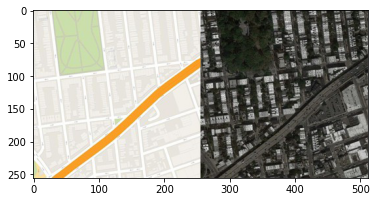

uint8


(600, 256, 256, 3)

In [14]:
# load data & data argumentation
def expand_image(input_img_data):
    assert type(input_img_data)==np.ndarray
    input_img = Image.fromarray(input_img_data)
    assert type(input_img)==Image.Image
    expanded_img = input_img.resize((286, 286),Image.ANTIALIAS) 
    return expanded_img

def crop_image(expanded_img, box):
    return np.array(expanded_img.crop(box))

def concat_n_show_images(image_data_list):
    img_data = np.concatenate(image_data_list, 1)
    imgplot = plt.imshow(img_data)
    plt.show()
    
def data_argumentation_for_single_image(real_img_data, cond_img_data, c_crop=5):
    expanded_real_img, expanded_cond_img = \
    map(expand_image, [real_img_data, cond_img_data])
    real_img_data_list = [real_img_data]
    cond_img_data_list = [cond_img_data]
    for i in range(c_crop):
        offset_x, offset_y = np.random.randint(0,30,2)
        box_ = (offset_x, offset_y, offset_x+256, offset_y+256)
        crop_image_fn = lambda img: crop_image(img, box=box_)
        cropped_real_img_data, cropped_cond_img_data =  \
        map(crop_image_fn, [expanded_real_img, expanded_cond_img])
        real_img_data_list.append(cropped_real_img_data)
        cond_img_data_list.append(cropped_cond_img_data)
    return real_img_data_list, cond_img_data_list

def load_data_with_data_argumentation(mode='train', print_sample=False):
    file_path = f"./datasets/" + dataset + "/" + mode + "/" # night2day, edges2shoes, maps, cityscapes, night2day, edges2handbags, edges2shoes, facades, maps
    n_image = len(glob.glob(file_path+"*.jpg"))
    real_img_data_list = []
    cond_img_data_list = []
    i = 0
    dirList = os.listdir(file_path)
    while(i < 400 and i < len(dirList)):
        item = dirList[i]
        if os.path.isfile(file_path+item):
            img_data = np.array(Image.open(file_path+item)) # (256, 512, 3)
            if(atoB):
              real_img_data, cond_img_data = img_data[:,:256,:], img_data[:,256:,:] # (256, 256, 3)
            else:
              real_img_data, cond_img_data = img_data[:,256:,:], img_data[:,:256,:] # (256, 256, 3)
            real_img_data_list_, cond_img_data_list_ =  \
            data_argumentation_for_single_image(real_img_data, cond_img_data)
            real_img_data_list += real_img_data_list_
            cond_img_data_list += cond_img_data_list_ 
        i = i + 1
    if print_sample:
        rand_idx = [0]
        #rand_idx = np.random.randint(0, len(real_img_data_list), 1)
        for i in rand_idx:
            concat_n_show_images([real_img_data_list[i], cond_img_data_list[i]])
    print(np.array(real_img_data_list).dtype)
    return np.array(real_img_data_list, dtype=np.uint8), np.array(cond_img_data_list, dtype=np.uint8)

real_imgs, cond_imgs = load_data_with_data_argumentation('test', print_sample=True)
real_imgs.shape # (480, 256, 256, 3)

In [15]:
torch.cuda.empty_cache()

In [16]:
train_loader = data.DataLoader(myDataset('train'), batch_size=10, shuffle=True)
test_loader = data.DataLoader(myDataset('test'), batch_size=10, shuffle=True)
val_loader = data.DataLoader(myDataset('val'), batch_size=10, shuffle=True)

uint8
uint8
uint8


#Generator

This code is the U-net generator as described in the paper. The Generator has encoder where the image is downsampled into latent vector and sent to the decoder to upsample it back from the latent vector. The difference between normal generators is that U-net also has skip connections between the encoder and decoders to hold style information from the inputs to the outputs.



**Model**

In [17]:
import torch
from torch import nn
  
class UnetGenerator(nn.Module):
    def __init__(self):
        super(UnetGenerator, self).__init__()
        # enc
        self.enc1 = nn.Conv2d(  3,  64, 4, stride=2, padding=2)
        self.enc2 = nn.Conv2d( 64, 128, 4, stride=2, padding=2)
        self.enc3 = nn.Conv2d(128, 256, 4, stride=2, padding=2)
        self.enc4 = nn.Conv2d(256, 512, 4, stride=2, padding=2)        
        self.enc5 = nn.Conv2d(512, 512, 4, stride=2, padding=2) 
        self.enc6 = nn.Conv2d(512, 512, 4, stride=2, padding=2) 
        self.enc7 = nn.Conv2d(512, 512, 4, stride=2, padding=2) 
        self.enc8 = nn.Conv2d(512, 512, 2, stride=2, padding=1) 
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_bn3 = nn.BatchNorm2d(256)
        self.enc_bn4 = nn.BatchNorm2d(512)        
        self.enc_bn5 = nn.BatchNorm2d(512) 
        self.enc_bn6 = nn.BatchNorm2d(512) 
        self.enc_bn7 = nn.BatchNorm2d(512) 
        self.enc_bn8 = nn.BatchNorm2d(512) 
        # dec
        self.dec1 = nn.ConvTranspose2d(  512, 512, 2, stride=1,  ) 
        self.dec2 = nn.ConvTranspose2d(512*2, 512, 2, stride=2, padding=1, output_padding=1) 
        self.dec3 = nn.ConvTranspose2d(512*2, 512, 4, stride=2, padding=2, output_padding=1) 
        self.dec4 = nn.ConvTranspose2d(512*2, 512, 4, stride=2, padding=2, output_padding=1)         
        self.dec5 = nn.ConvTranspose2d(512*2, 256, 4, stride=2, padding=2, output_padding=1)  
        self.dec6 = nn.ConvTranspose2d(256*2, 128, 4, stride=2, padding=2, output_padding=1)  
        self.dec7 = nn.ConvTranspose2d(128*2,  64, 4, stride=2, padding=2, output_padding=1)  
        self.dec8 = nn.ConvTranspose2d( 64*2,   3, 4, stride=2, padding=2,)
        self.dec_bn1 = nn.BatchNorm2d(512)
        self.dec_bn2 = nn.BatchNorm2d(512)
        self.dec_bn3 = nn.BatchNorm2d(512)        
        self.dec_bn4 = nn.BatchNorm2d(512) 
        self.dec_bn5 = nn.BatchNorm2d(256) 
        self.dec_bn6 = nn.BatchNorm2d(128) 
        self.dec_bn7 = nn.BatchNorm2d(64) 
        # act
        self.enc_act = nn.LeakyReLU(0.2)
        self.dec_act = nn.ReLU()
        
        
    def forward(self, x):
        # enc
        e1 = self.enc1(x)                               #;print('1:', e1.shape)
        e2 = self.enc_bn2(self.enc_act(self.enc2(e1)))  #;print('e2:', e2.shape)
        e3 = self.enc_bn3(self.enc_act(self.enc3(e2)))  #;print('e3:', e3.shape)
        e4 = self.enc_bn4(self.enc_act(self.enc4(e3)))  #;print('e4:', e4.shape)
        e5 = self.enc_bn5(self.enc_act(self.enc5(e4)))  #;print('e5:', e5.shape)
        e6 = self.enc_bn6(self.enc_act(self.enc6(e5)))  #;print('e6:', e6.shape)
        e7 = self.enc_bn7(self.enc_act(self.enc7(e6)))  #;print('e7:', e7.shape)
        e8 = self.enc_bn8(self.enc_act(self.enc8(e7)))  #;print('e8:', e8.shape)
        # The skip connections are here below and these are specialty for the unet generator.
        d1 = self.dec_bn1(self.dec_act(self.dec1(e8)))  #;print('d1:', d1.shape)
        d1c = torch.cat([d1, e7], 1)                    #;print('d1c:', d1c.shape)
        d2 = self.dec_bn2(self.dec_act(self.dec2(d1c))) #;print('d2:', d2.shape)
        d2c = torch.cat([d2, e6], 1)                    #;print('d2c:', d2c.shape)
        d3 = self.dec_bn3(self.dec_act(self.dec3(d2c))) #;print('d3:', d3.shape)
        d3c = torch.cat([d3, e5], 1)                    #;print('d3c:', d3c.shape)
        d4 = self.dec_bn4(self.dec_act(self.dec4(d3c))) #;print('d4:', d4.shape)
        d4c = torch.cat([d4, e4], 1)                    #;print('d4c:', d4c.shape)
        d5 = self.dec_bn5(self.dec_act(self.dec5(d4c))) #;print('d5:', d5.shape)
        d5c = torch.cat([d5, e3], 1)                    #;print('d5c:', d5c.shape)
        d6 = self.dec_bn6(self.dec_act(self.dec6(d5c))) #;print('d6:', d6.shape)
        d6c = torch.cat([d6, e2], 1)                    #;print('d6c:', d6c.shape)
        d7 = self.dec_bn7(self.dec_act(self.dec7(d6c))) #;print('d7:', d7.shape)
        d7c = torch.cat([d7, e1], 1)                    #;print('d7c:', d7c.shape)
        d8 = nn.Tanh()(self.dec8(d7c))                  #;print('d8:', d8.shape)        
        
        return d8
    
# G = UnetGenerator().cuda()
# gen_img = G(cond_img)
# gen_img.shape # torch.Size([1, 3, 256, 256])

#Discriminator
This is the Patch-Gan as described in the paper. The Discriminator works classifies if each N x N patch is real or fake and in the end it outputs an average response of whether the pair of images are real or fake.

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3*2,  64, 4, stride=2, padding=2)
        self.conv2 = nn.Conv2d( 64, 128, 4, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=2)        
        self.conv_bn1 = nn.BatchNorm2d(64)
        self.conv_bn2 = nn.BatchNorm2d(128)
        self.conv_bn3 = nn.BatchNorm2d(256)        
        self.conv_bn4 = nn.BatchNorm2d(512) 
        self.fc = nn.Linear(512*17*17, 1)
        self.conv_act = nn.LeakyReLU(0.2)
        self.op_act = nn.Sigmoid()
        
    def forward(self, x):
        # enc
        x = self.conv_bn1(self.conv_act(self.conv1(x)))  #;print('L1:', x.shape)
        x = self.conv_bn2(self.conv_act(self.conv2(x)))  #;print('L2:', x.shape)  
        x = self.conv_bn3(self.conv_act(self.conv3(x)))  #;print('L3:', x.shape)
        x = self.conv_bn4(self.conv_act(self.conv4(x)))  #;print('L4:', x.shape)
        x = self.fc(x.view(x.shape[0], -1))              #;print('out:', x.shape)
        return self.op_act(x)
    
# D = Discriminator().cuda()
# y = D(torch.cat([gen_img, cond_img],1))
# y.shape

# Forward and Loss functions

In the forward_n_get_loss function the input is given to the Generator and it outputs a fake image that is hopefully close to reality as possible. Then two pairs of images are created. The two pairs are real pair and the fake pair. The real pair contains the ground truth image and the conditional image and the fake pair contains the fake image created by the generator and the conditional image. The losses are computed for both the generator and the discriminator using the Binary Cross Entropy loss function. The Discriminator tries to guess the fake pair as fake and real pair as real. The Generator learns from the fake probability guess of the Discriminator and along with the L1 loss between the real image and the fake image.

In [19]:
def forward_n_get_loss(real_img, cond_img, G, D, c=100):
    fake_img = G(cond_img) 
    real_pair = torch.cat([real_img, cond_img], 1)
    fake_pair = torch.cat([fake_img, cond_img], 1)
    prob_real, prob_fake = D(real_pair), D(fake_pair).detach()
    prob_fake2 = prob_fake.clone()
    # loss_D
    loss_D_real = nn.BCELoss()(prob_real, torch.ones_like(prob_real))
    loss_D_fake = nn.BCELoss()(prob_fake, torch.zeros_like(prob_fake))
    loss_D = (loss_D_real + loss_D_fake) *0.5
    # loss_G
    loss_G_fake = nn.BCELoss()(prob_fake2, torch.ones_like(prob_fake2))
    loss_G_L1 = nn.L1Loss()(fake_img, real_img)
    loss_G = loss_G_fake + c*loss_G_L1
    return loss_D, loss_G, loss_D_real, loss_D_fake, loss_G_fake, loss_G_L1

In [20]:
# build model 
use_cuda = torch.cuda.is_available()
print('use_cuda:', use_cuda)
if use_cuda:
    G = UnetGenerator().cuda()
    D = Discriminator().cuda()
else:
    G = UnetGenerator()
    D = Discriminator()

use_cuda: True


#Training

Using Adam Solver with betas 0.5 and 0.999 and with a small learning rate of 
0.0002

In [21]:
from torch.optim import Adam
optimizer_G = Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [22]:
rescale_fn = lambda t : torch.clamp(((t+1)*0.5*256).long(), min=0, max=255)
def show_img(fake_img):
    #print(fake_img.shape)
    data = rescale_fn(fake_img).cpu().detach().numpy().transpose((1, 2, 0))
    #print(data.shape)
    plt.axis('off')
    imgplot = plt.imshow(data)

def sample_img(G, data_loader, PATH="test.jpg"):
    G.eval()
    real_img_batch, cond_img_batch = next(iter(data_loader))
    if use_cuda: real_img_batch, cond_img_batch = real_img_batch.cuda(), cond_img_batch.cuda() 
    fake_img_batch = G(cond_img_batch)
    img_batch = torch.cat((real_img_batch, cond_img_batch, fake_img_batch), 3)
    #print(img_batch.shape)
    show_img(img_batch[0])
    plt.savefig(PATH)
    plt.show()
    G.train()

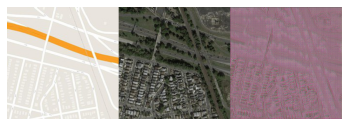

In [23]:
# test
#G.load_state_dict(torch.load("model/G_0269"))
sample_img(G, val_loader)

#Training
Training both the Generator and Discriminator for 200 epochs and recording the results every 10 epochs. The loss function is run and both the Generator and Discriminator and the parameters of both are them are updated simulataneously or there is an option to run them seperately. The loss info is saved into a csv file for analyzing purposes later on.

[0] {'loss_D': 5.8134, 'loss_G': 10.5235, 'loss_D_real': 0.0, 'loss_D_fake': 11.6268, 'loss_G_fake': 0.0, 'loss_G_L1': 0.1052}, time_cost: 0.55 min
0.1052


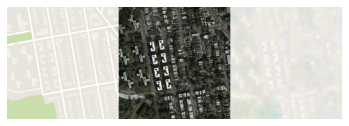

[9] {'loss_D': 37.3567, 'loss_G': 8.8399, 'loss_D_real': 0.0, 'loss_D_fake': 74.7134, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0884}, time_cost: 5.00 min
0.0884


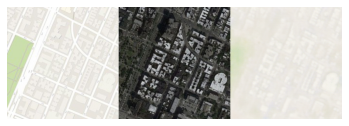

[19] {'loss_D': 45.7971, 'loss_G': 6.3102, 'loss_D_real': 0.0, 'loss_D_fake': 91.5942, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0631}, time_cost: 5.55 min
0.0631


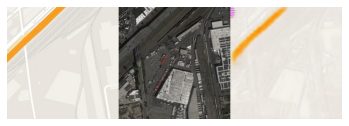

[29] {'loss_D': 50.0, 'loss_G': 5.2099, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0521}, time_cost: 5.55 min
0.0521


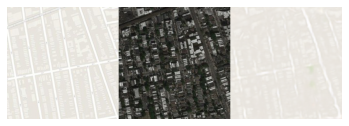

[39] {'loss_D': 50.0, 'loss_G': 4.4315, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0443}, time_cost: 5.55 min
0.0443


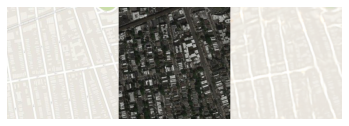

[49] {'loss_D': 50.0, 'loss_G': 3.8355, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0384}, time_cost: 5.55 min
0.0384


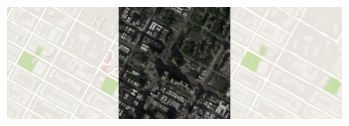

[59] {'loss_D': 50.0, 'loss_G': 3.3755, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0338}, time_cost: 5.55 min
0.0338


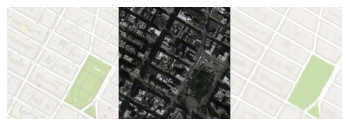

[69] {'loss_D': 50.0, 'loss_G': 3.7945, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0379}, time_cost: 5.55 min
0.0379


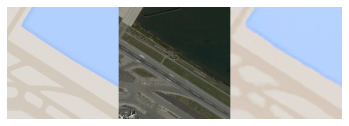

[79] {'loss_D': 50.0, 'loss_G': 3.872, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0387}, time_cost: 5.55 min
0.0387


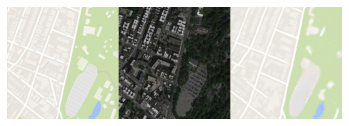

[89] {'loss_D': 50.0, 'loss_G': 2.7395, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0274}, time_cost: 5.55 min
0.0274


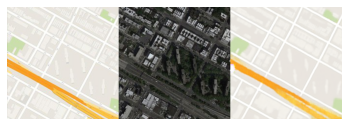

[99] {'loss_D': 50.0, 'loss_G': 3.2578, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0326}, time_cost: 5.54 min
0.0326


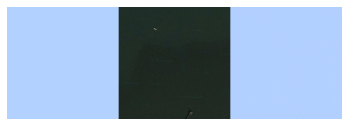

[109] {'loss_D': 50.0, 'loss_G': 2.3489, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0235}, time_cost: 5.54 min
0.0235


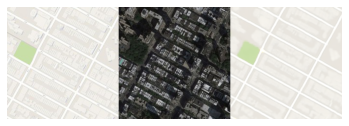

[119] {'loss_D': 50.0, 'loss_G': 3.5543, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0355}, time_cost: 5.55 min
0.0355


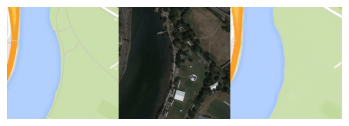

[129] {'loss_D': 50.0, 'loss_G': 2.6652, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0267}, time_cost: 5.54 min
0.0267


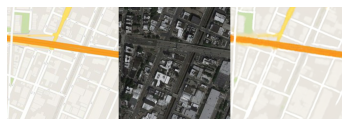

[139] {'loss_D': 50.0, 'loss_G': 2.9391, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0294}, time_cost: 5.54 min
0.0294


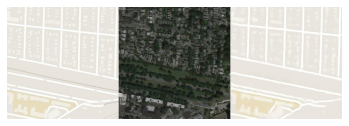

[149] {'loss_D': 50.0, 'loss_G': 2.5091, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0251}, time_cost: 5.54 min
0.0251


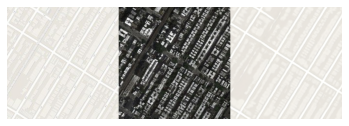

[159] {'loss_D': 50.0, 'loss_G': 2.3662, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0237}, time_cost: 5.54 min
0.0237


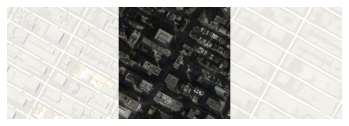

[169] {'loss_D': 50.0, 'loss_G': 2.9003, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.029}, time_cost: 5.54 min
0.029


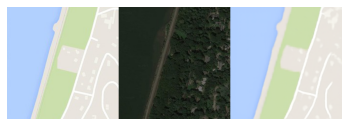

[179] {'loss_D': 50.0, 'loss_G': 2.8, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.028}, time_cost: 5.54 min
0.028


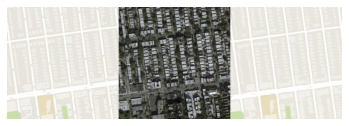

[189] {'loss_D': 50.0, 'loss_G': 2.8474, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0285}, time_cost: 5.54 min
0.0285


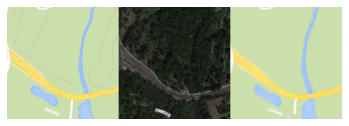

[199] {'loss_D': 50.0, 'loss_G': 2.2056, 'loss_D_real': 0.0, 'loss_D_fake': 100.0, 'loss_G_fake': 0.0, 'loss_G_L1': 0.0221}, time_cost: 5.54 min
0.0221


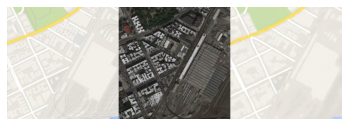

In [24]:
# train!
import time
import os
start_epo = 0
n_epochs = 200
print_freq = 10
st = time.time()
loss2npval = lambda loss : np.mean(loss.cpu().data.numpy()).round(4)
loss_names = ["loss_D", "loss_G", "loss_D_real", "loss_D_fake",  \
              "loss_G_fake", "loss_G_L1"]
update_DnG_together = True
G.train()
D.train()
if os.path.exists("./datasets/" + dataset + "/LossSnap/LossSnap.csv"):
    os.remove("./datasets/" + dataset + "/LossSnap/LossSnap.csv")
# file path make dir LossSnap
if(not(os.path.isdir("./datasets/" + dataset + "/LossSnap/"))):
    os.mkdir("./datasets/" + dataset + "/LossSnap/")
lossesSnap = open("./datasets/" + dataset + "/LossSnap/" + dataset + "LossSnap.csv", "a")
# writing the heading into the dataset
lossesSnap.write("epoch lossD lossG lossDreal lossDfake lossGfake lossGL1\n")
for epo in range(n_epochs):
    for batch_No, (real_img_batch, cond_img_batch) in enumerate(train_loader):
        
        if use_cuda: real_img_batch, cond_img_batch = real_img_batch.cuda(), cond_img_batch.cuda() 

        # forward and get loss
        c = 100
        #c = (1-(epo+1)/n_epochs)*100+1 # decay c with epoch    
        losses = forward_n_get_loss(real_img_batch, cond_img_batch, G, D, c=c )
        
        update_D, update_G = (True, True) if update_DnG_together  \
        else ((epo+batch_No)%2!=0, (epo+batch_No)%2==0  )
        
        # update D
        if update_D:
            optimizer_D.zero_grad()
            losses[0].backward(retain_graph=True)
            optimizer_D.step()
            
        # update G
        if update_G:
            optimizer_G.zero_grad()
            losses[1].backward(retain_graph=True)
            optimizer_G.step()
        
    if epo==0 or epo%print_freq==(print_freq-1) or epo==n_epochs-1: 
        et = time.time() 
        loss_vals = map(loss2npval, losses)
        loss_info = dict(zip(loss_names,loss_vals))
        print("[{}] {}, time_cost: {:.2f} min" \
              .format( epo, loss_info, (et-st)/60 ))
        print(loss_info["loss_G_L1"])
        lossesSnap.write(str(epo) + " " 
                         +  str(loss_info["loss_D"]) + " " 
                         +  str(loss_info["loss_G"]) + " " 
                         +  str(loss_info["loss_D_real"]) + " " 
                         +  str(loss_info["loss_D_fake"]) + " "
                         +  str(loss_info["loss_G_fake"]) + " "
                         +  str(loss_info["loss_G_L1"]) + "\n")
        st = et # update st
        # save out
        this_epo_str = str(epo+start_epo).zfill(4) 
        torch.save(G.state_dict(), f"{model_name}/model/G_{this_epo_str}")
        torch.save(D.state_dict(), f"{model_name}/model/D_{this_epo_str}")
        sample_img(G, train_loader, f"{model_name}/fig/{this_epo_str}.jpg")
lossesSnap.close()

In [30]:
!mv /content/datasets /content/drive/MyDrive/CSC413project